In [1]:
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pywt
import numpy as np

In [42]:
# 图像类
class DNAImage:
    def __init__(self, image:Image):
        self.image = image
        self.level = 0
        self.shape = None
        self.RGB_array = None          # RGB通道图像矩阵，利用调色板和原始图像矩阵还原 维度（x, y, 3)
        self.RGB_img = None
        self.YCbCr_array = None
        self.YCbCr_img = None
        self.DWT_array = None
        self.Yc = None
        self.Cbc = None
        self.Crc = None
        
        self.IquantValues = [[], [], []]
        self.quantYc = []  #量化后的直流系数
        self.quantCbc = []
        self.quantCrc = []
        self.quantAcs = None  # 量化后的交流系数    # [ [()()... 级数 ]Yac  [ ()()... 级数  ]Cbac  [()()... 级数   ]Crac]
        self.info_init()
        
    def info_init(self):
        self.RGB_img = self.image.convert("RGB")
        self.YCbCr_img = self.RGB_img.convert("YCbCr")
        self.RGB_array = np.array(self.RGB_img)
        self.YCbCr_array = np.array(self.YCbCr_img)
        print(self.YCbCr_array.shape)
        
    def DWT(self, level):
        self.level = level
        Yc = pywt.wavedec2(self.YCbCr_array[:,:,0], 'db2', mode="periodization", level=level)
        Cbc = pywt.wavedec2(self.YCbCr_array[:,:,1], 'db2', mode="periodization", level=level)
        Crc = pywt.wavedec2(self.YCbCr_array[:,:,2], 'db2', mode="periodization", level=level)
        self.Yc = Yc
        self.Cbc = Cbc
        self.Crc = Crc
        self.Quantization()
        return self
    
    def Quantization(self):
        # 量化
        # 直流分量量化
        maxV = self.Yc[0].max()
        minV = self.Yc[0].min()
        delta = (maxV - minV) / 255
        Yc0 = np.uint8(self.Yc[0] * 255/ delta / (maxV-minV))
        self.quantYc=Yc0
        self.IquantValues[0].append((minV, maxV, delta))
        
        maxV = self.Cbc[0].max()
        minV = self.Cbc[0].min()
        delta = (maxV - minV) / 255
        Cbc0 = np.uint8(self.Cbc[0] * 255/ delta / (maxV-minV))
        self.quantCbc=Cbc0
        self.IquantValues[1].append((minV, maxV, delta))
        
        maxV = self.Crc[0].max()
        minV = self.Crc[0].min()
        delta = (maxV - minV) / 255
        Crc0 = np.uint8(self.Crc[0] * 255/ delta / (maxV-minV))
        self.quantCrc=Crc0
        self.IquantValues[2].append((minV, maxV, delta))
        
        self.quantAcs = [[] for _ in range(3)]   # [ [()()... 级数 ]Yac  [ ()()... 级数  ]Cbac  [()()... 级数   ]Crac]
        # 交流分量递归量化
        for i in range(self.level):
            tempYac = []
            tempCbac = []
            tempCrac = []
            for j in range(3):
                maxV = self.Yc[i+1][j].max()
                minV = self.Yc[i+1][j].min()
                delta = (maxV - minV) / 255
                self.IquantValues[0].append((minV, maxV, delta))
                tempYac.append(np.uint8(self.Yc[i+1][j] * 255 / delta / (maxV - minV)))
                
                maxV = self.Cbc[i+1][j].max()
                minV = self.Cbc[i+1][j].min()
                delta = (maxV - minV) / 255
                self.IquantValues[1].append((minV, maxV, delta))
                tempCbac.append(np.uint8(self.Cbc[i+1][j] * 255 / delta / (maxV - minV)))
                
                maxV = self.Crc[i+1][j].max()
                minV = self.Crc[i+1][j].min()
                delta = (maxV - minV) / 255
                self.IquantValues[2].append((minV, maxV, delta))
                tempCrac.append(np.uint8(self.Crc[i+1][j] * 255 / delta / (maxV - minV)))
            Yac = (tempYac[0], tempYac[1], tempYac[2])
            Cbc = (tempCbac[0],tempCbac[1],tempCbac[2])
            Crc = (tempCrac[0],tempCrac[1],tempCrac[2])
            self.quantAcs[0].append(Yac)
            self.quantAcs[1].append(Cbc)
            self.quantAcs[2].append(Crc)
    
    def show(self):
        plt.imshow(self.RGB_array/255)

(668, 1000, 3)
[array([[54.69022691, 60.05953724, 62.57628407, ..., 54.8205944 ,
        58.10617061, 52.36754995],
       [66.54815791, 70.2589746 , 72.0625    , ..., 64.5625    ,
        63.4375    , 61.13517696],
       [69.68541744, 72.0625    , 71.9910254 , ..., 66.1875    ,
        64.5625    , 62.58942379],
       ...,
       [37.38725953, 32.83165156, 32.21113886, ..., 40.03677858,
        36.0044873 , 36.22548095],
       [33.66418332, 39.59839838, 41.90400635, ..., 44.02780398,
        40.53469602, 38.55232304],
       [30.72372056, 39.65104359, 40.97131582, ..., 39.5036071 ,
        44.61843014, 36.83613886]]), (array([[  2.18717783,   2.69943735,   2.44495005, ...,   2.32563972,
          0.79334844,   2.2999183 ],
       [ -0.13725953,   0.46650635,  -0.01674682, ...,   0.23325318,
          0.01674682,  -0.3125    ],
       [ -0.3080127 ,   0.23325318,  -0.03349365, ...,   0.44975953,
          0.23325318,  -0.05024047],
       ...,
       [  2.99431033,  -1.19527223,  -2

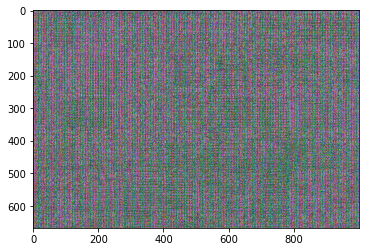

In [215]:
dna = DNAImage(Image.open("2.jpg"))
dna.DWT(1)

yy = [np.float32(dna.quantYc) * 255 * dna.IquantValues[0][0][2] / (dna.IquantValues[0][0][1] - dna.IquantValues[0][0][0]), 
      (np.float32(dna.quantAcs[0][0][0]) * (dna.IquantValues[0][0][1] - dna.IquantValues[0][0][0]) * dna.IquantValues[0][0][2] / 255,
      np.float32(dna.quantAcs[0][0][1]) * (dna.IquantValues[0][1][1] - dna.IquantValues[0][1][0]) * dna.IquantValues[0][1][2] / 255,
      np.float32(dna.quantAcs[0][0][2]) * (dna.IquantValues[0][2][1] - dna.IquantValues[0][2][0])* dna.IquantValues[0][2][2] / 255) ]
i = 1
bb = [dna.quantCbc * 255 * dna.IquantValues[i][0][2] / (dna.IquantValues[i][0][1] - dna.IquantValues[i][0][0]), 
      (dna.quantAcs[i][0][0] * 255 * dna.IquantValues[i][0][2] / (dna.IquantValues[i][0][1] - dna.IquantValues[i][0][0]),
      dna.quantAcs[i][0][1] * 255 * dna.IquantValues[i][1][2] / (dna.IquantValues[i][1][1] - dna.IquantValues[i][1][0]),
      dna.quantAcs[i][0][2] * 255 * dna.IquantValues[i][2][2] / (dna.IquantValues[i][2][1] - dna.IquantValues[i][2][0]))]
i = 2
rr = [dna.quantCrc * 255 * dna.IquantValues[i][0][2] / (dna.IquantValues[i][0][1] - dna.IquantValues[i][0][0]), 
      (dna.quantAcs[i][0][0] * 255 * dna.IquantValues[i][0][2] / (dna.IquantValues[i][0][1] - dna.IquantValues[i][0][0]),
      dna.quantAcs[i][0][1] * 255 * dna.IquantValues[i][1][2] / (dna.IquantValues[i][1][1] - dna.IquantValues[i][1][0]),
      dna.quantAcs[i][0][2] * 255 * dna.IquantValues[i][2][2] / (dna.IquantValues[i][2][1] - dna.IquantValues[i][2][0]))]

y = pywt.waverec2(yy, "db2", mode="periodization")
b = pywt.waverec2(bb, "db2", mode="periodization")
r = pywt.waverec2(rr, "db2", mode="periodization")
t = np.dstack((y, b, r))
img = Image.fromarray(t, mode="YCbCr").convert("RGB")
# rgb = dna.RGB_array

# Yc = pywt.wavedec2(rgb[:,:,0], 'db2', mode="periodization", level=1)
# Cbc = pywt.wavedec2(rgb[:,:,1], 'db2', mode="periodization", level=1)
# Crc = pywt.wavedec2(rgb[:,:,2], 'db2', mode="periodization", level=1)
# y = Yc[0] / np.abs(Yc[0]).max() * 255
# Cb = Cbc[0] / np.abs(Cbc[0]).max()* 255
# Cr = Crc[0] / np.abs(Crc[0]).max()* 255
# t = np.dstack((np.uint8(y), np.uint8(Cb), np.uint8(Cr)))

plt.imshow(img)

In [43]:
dna = DNAImage(Image.open("2.jpg"))
dna.DWT(1)

(668, 1000, 3)


[[[ 33 137 116]
  [ 33 137 116]
  [ 34 137 117]
  ...
  [ 30 137 117]
  [ 30 137 118]
  [ 30 137 117]]

 [[ 33 137 116]
  [ 34 137 116]
  [ 34 137 116]
  ...
  [ 30 137 117]
  [ 30 137 117]
  [ 29 137 117]]

 [[ 35 137 116]
  [ 34 137 116]
  [ 33 137 116]
  ...
  [ 30 137 117]
  [ 31 137 117]
  [ 31 137 117]]

 ...

 [[ 14 136 131]
  [ 16 136 131]
  [ 21 136 131]
  ...
  [ 21 134 130]
  [ 16 134 130]
  [ 18 134 130]]

 [[ 15 136 130]
  [ 18 136 129]
  [ 21 136 131]
  ...
  [ 22 134 130]
  [ 16 134 130]
  [ 19 134 130]]

 [[ 17 136 129]
  [ 17 136 129]
  [ 20 136 131]
  ...
  [ 22 134 130]
  [ 16 134 130]
  [ 18 134 130]]]


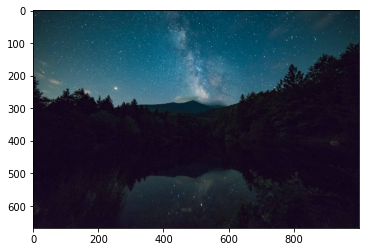

In [44]:

maxV = dna.Yc[0].max()
minV = dna.Yc[0].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Yc[0] - minV) / delta)
y =  q * delta + minV

maxV = dna.Yc[1][0].max()
minV = dna.Yc[1][0].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Yc[1][0] - minV) / delta)
y0 = q * delta + minV

maxV = dna.Yc[1][1].max()
minV = dna.Yc[1][1].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Yc[1][1] - minV) /  delta)
y1 = q * delta + minV

maxV = dna.Yc[1][2].max()
minV = dna.Yc[1][2].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Yc[1][2] - minV) /delta )
y2 = q * delta + minV

yy = [y, (y0, y1, y2)]
iy = pywt.waverec2(yy, "db2", mode="periodization")


maxV = dna.Cbc[0].max()
minV = dna.Cbc[0].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Cbc[0] - minV) / delta )
y = q * delta + minV

maxV = dna.Cbc[1][0].max()
minV = dna.Cbc[1][0].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Cbc[1][0] - minV)/ delta)
y0 = q * delta + minV

maxV = dna.Cbc[1][1].max()
minV = dna.Cbc[1][1].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Cbc[1][1] - minV) / delta)
y1 = q * delta + minV

maxV = dna.Cbc[1][2].max()
minV = dna.Cbc[1][2].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Cbc[1][2] - minV)/ delta)
y2 = q * delta + minV

bb = [y, (y0, y1, y2)]
ib = pywt.waverec2(bb, "db2", mode="periodization")


maxV = dna.Crc[0].max()
minV = dna.Crc[0].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Crc[0] - minV) / delta)
y = q * delta + minV

maxV = dna.Crc[1][0].max()
minV = dna.Crc[1][0].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Crc[1][0] - minV) / delta)
y0 = q * delta + minV

maxV = dna.Crc[1][1].max()
minV = dna.Crc[1][1].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Crc[1][1] - minV)/ delta)
y1 = q * delta + minV

maxV = dna.Crc[1][2].max()
minV = dna.Crc[1][2].min()
delta = (maxV - minV) / 255
q = np.uint8((dna.Crc[1][2] - minV)/ delta)
y2 = q * delta + minV # (maxV - minV) * q * delta / 255


rr = [y, (y0, y1, y2)]
ir = pywt.waverec2(rr, "db2", mode="periodization")

pic = np.dstack((np.uint8(iy), np.uint8(ib), np.uint8(ir)))
img = Image.fromarray(pic, mode="YCbCr").convert("RGB")
print(pic)
plt.imshow(img)

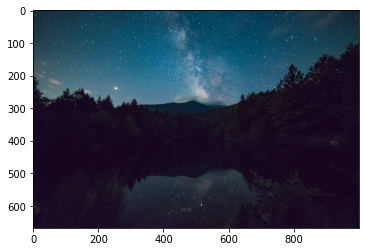

In [240]:
iy = pywt.waverec2(dna.Yc, "db2", mode="periodization")
plt.imshow(dna.RGB_array)